In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
import re
sns.set(style='whitegrid')
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('data/raw/clinical_notes_diagnosis_prediction_5000.csv')
df = df.copy()

In [3]:
df.head()

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus


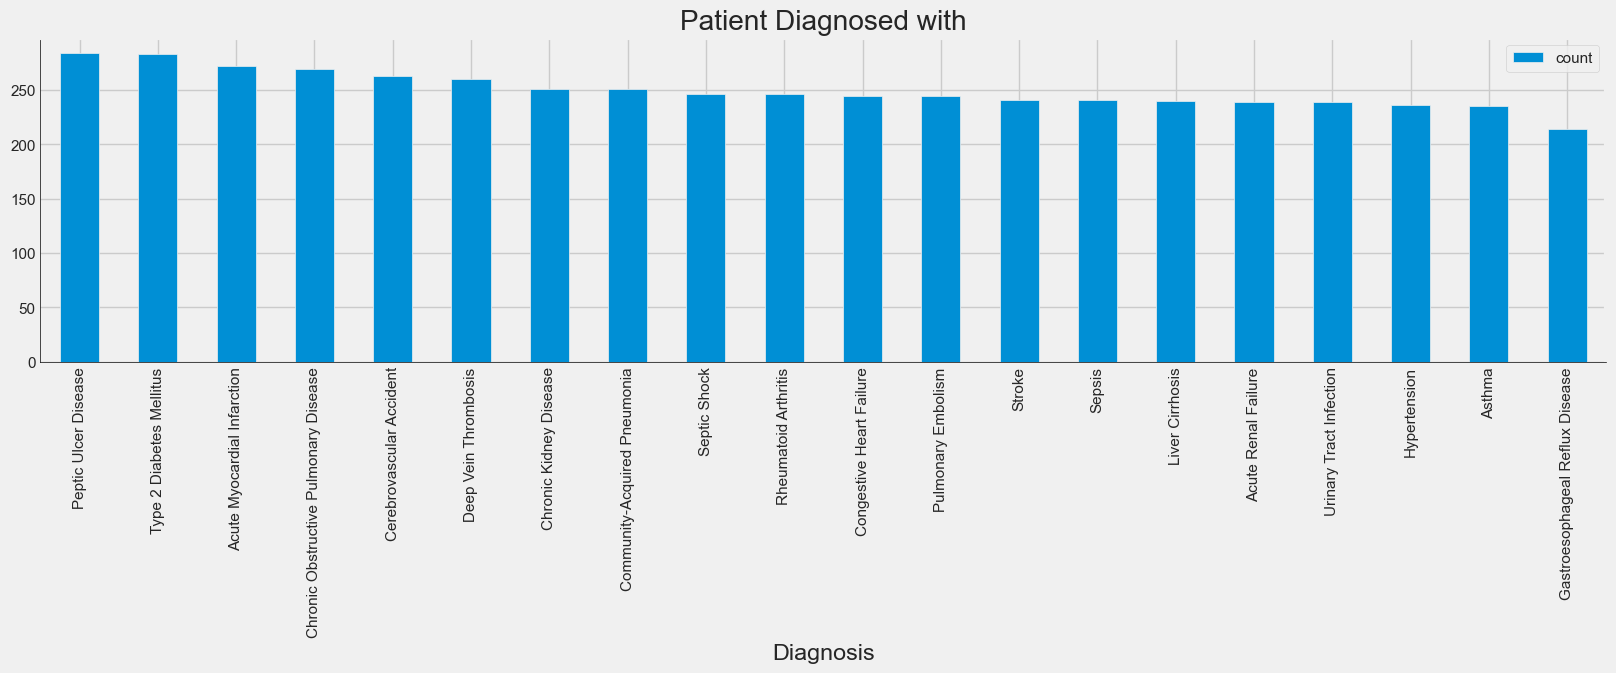

In [4]:
df['Diagnosis'].value_counts().reset_index().set_index('Diagnosis').plot(kind='bar', figsize=(18, 4))
plt.title('Patient Diagnosed with')
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.5)
plt.grid(True)
plt.show()

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+','',text)
    text = re.sub(r'[^a-z\s]','',text)
    text = re.sub(r'\s+',' ',text).strip()
    text = ' '.join([word for word in text.split(' ') if word not in stop_word]) 
    return text

def label_convert(text):
    le = LabelEncoder()
    return le.fit_transform(text)

In [6]:
df['Clinical Notes'] = df['Clinical Notes'].apply(clean_text)

In [7]:
le = LabelEncoder()
df['Diagnosis'] = le.fit_transform(df['Diagnosis'])

In [8]:
df

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,9
1,yearold male history heavy alcohol use present...,11
2,yearold male history diabetes presents hypoten...,16
3,yearold male presents heartburn regurgitation ...,9
4,yearold female history obesity hypertension pr...,18
...,...,...
4995,yearold male history heavy alcohol use present...,11
4996,yearold female presents swelling pain redness ...,8
4997,yearold male history heavy alcohol use present...,11
4998,yearold female presents swelling pain redness ...,8


In [9]:
x = df['Clinical Notes']
y = df['Diagnosis']
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.2, shuffle=True, stratify = y)

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_embed = tokenizer(list(x_train), padding = True, truncation = True, max_length = 512)
test_embed = tokenizer(list(x_test), padding = True, truncation = True, max_length = 512)

In [11]:
#-----------train-------------
train_data = Dataset.from_dict({'input_ids':train_embed['input_ids'],
                                'attention_mask':train_embed['attention_mask'],'labels':y_train.tolist()})
#--------test----------------
test_data = Dataset.from_dict({'input_ids':test_embed['input_ids'],
                                'attention_mask':test_embed['attention_mask'],'labels':y_test.tolist()})

In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(le.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
trainargs = TrainingArguments(
    output_dir = './results',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5, 
    weight_decay=0.01,
    logging_dir = './logs',
    logging_steps = 10,
    lr_scheduler_type = 'linear',
    warmup_steps = 500,
    load_best_model_at_end = True,
    metric_for_best_model='eval_loss',
    save_total_limit=3,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model = model,
    args = trainargs,
    train_dataset=train_data,
    eval_dataset = test_data
)

trainer.train()

SyntaxError: positional argument follows keyword argument (3014492909.py, line 25)